In [ ]:
import os

os.environ['KAGGLE_KEY'] = 'KGAT_ed2c604fa2957a574d3151535*******'
os.environ['KAGGLE_USERNAME'] = '*****' # My Kaggle profile name

# Installing the Kaggle library
!pip install -q kaggle

!pip install torchinfo

In [2]:
# Download the dataset as zip
!kaggle datasets download -d aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented

import zipfile
import os

# Open the zip file
zip_file_name = "alzheimers-multiclass-dataset-equal-and-augmented.zip"
target_dir = "alzheimer_final_data"

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(target_dir)
    print(f"Dataset successfully moved to '{target_dir}'")

# See what we have inside the directory
print("\nMain folder contents:", os.listdir(target_dir))

Dataset URL: https://www.kaggle.com/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented
License(s): apache-2.0
 82% 326M/398M [00:00<00:00, 1.71GB/s]
100% 398M/398M [00:00<00:00, 1.71GB/s]
Dataset successfully moved to 'alzheimer_final_data'

Main folder contents: ['combined_images']


In [3]:
#Installing required packages
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import ToTensor
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import random
from pathlib import Path
from PIL import Image
import numpy as np
import shutil
from tqdm import tqdm
from timeit import default_timer
from torchinfo import summary
import random
import shutil
from pathlib import Path

##Split our data into `train`, `test` and `validation` folders

In [4]:
# Original dataset folder
data_dir = Path("/content/alzheimer_final_data/combined_images")

# Output folders
train_dir = Path("/content/alzheimer_final_data/train")
val_dir   = Path("/content/alzheimer_final_data/val")
test_dir  = Path("/content/alzheimer_final_data/test")

# Create folders
for d in [train_dir, val_dir, test_dir]:
    d.mkdir(parents=True, exist_ok=True)

# Get class names
classes = [d.name for d in data_dir.iterdir() if d.is_dir()]

# Images per split
TRAIN_PER_CLASS = 5000
VAL_PER_CLASS   = 2500

for cls in classes:
    cls_dir = data_dir / cls
    images = list(cls_dir.glob("*.jpg"))
    random.shuffle(images)

    # Safety check
    assert len(images) >= TRAIN_PER_CLASS + VAL_PER_CLASS, \
        f"There is not any data in {cls}!"

    train_imgs = images[:TRAIN_PER_CLASS]
    val_imgs   = images[TRAIN_PER_CLASS:TRAIN_PER_CLASS + VAL_PER_CLASS]
    test_imgs  = images[TRAIN_PER_CLASS + VAL_PER_CLASS:]

    # Create class folders
    (train_dir / cls).mkdir(exist_ok=True)
    (val_dir / cls).mkdir(exist_ok=True)
    (test_dir / cls).mkdir(exist_ok=True)

    # Copy files
    for img in train_imgs:
        shutil.copy(img, train_dir / cls / img.name)

    for img in val_imgs:
        shutil.copy(img, val_dir / cls / img.name)

    for img in test_imgs:
        shutil.copy(img, test_dir / cls / img.name)

    print(f"{cls}: Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")

print("Train / Validation / Test folders successfully created!")


NonDemented: Train=5000, Val=2500, Test=5300
ModerateDemented: Train=5000, Val=2500, Test=2500
MildDemented: Train=5000, Val=2500, Test=2500
VeryMildDemented: Train=5000, Val=2500, Test=3700
Train / Validation / Test folders successfully created!


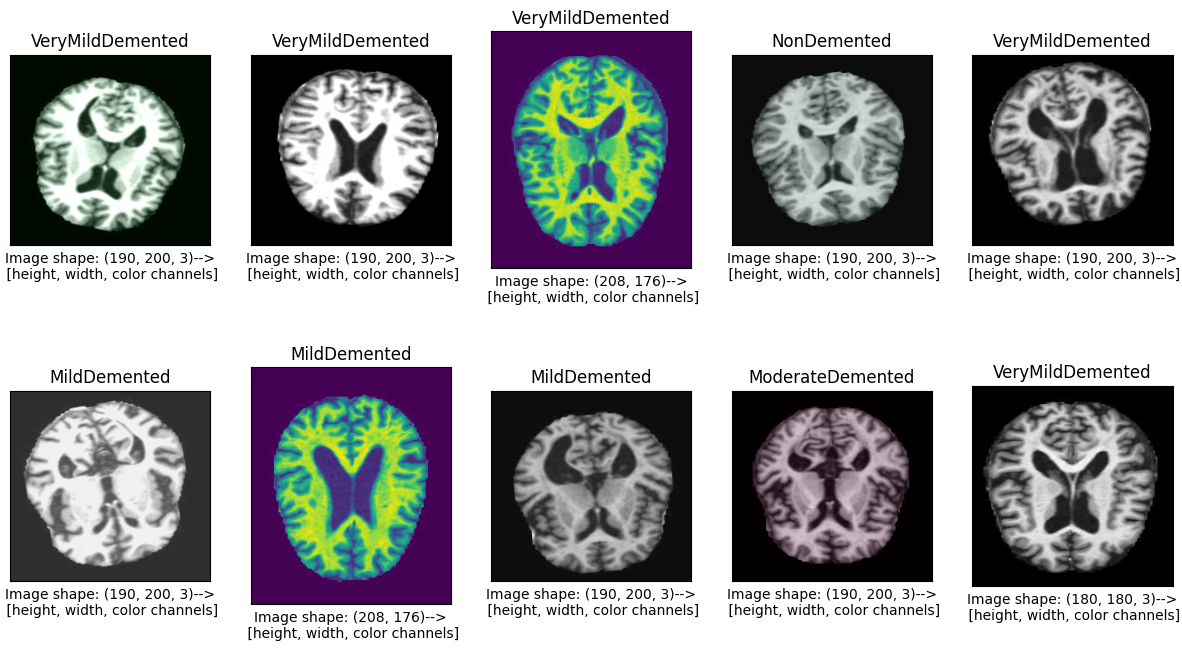

In [5]:
#Dir we are working with
data_file = Path("/content/alzheimer_final_data/combined_images")

#Get all image paths as a list
image_path_list = list(data_file.glob("*/*.jpg"))

#Take random samples
samples = random.sample(image_path_list, 10)

#Plot a figure
plt.figure(figsize=(15,8))

#Loop through all images
for i, sample in enumerate(samples):

  #Take image class from path
  sample_class = sample.parent.stem

  #Open the sample image
  img = Image.open(sample)

  #Image as an array
  img_array = np.asanyarray(img)

  #Plot an image
  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(sample_class)
  plt.xlabel(f"Image shape: {img_array.shape}-->\n [height, width, color channels]")
  plt.xticks([])
  plt.yticks([])


###After visualising the images above, you can notice that they do not all have the same number of **color channels**. Most of the images have ***three color channels***, while some have only one. Therefore, I am going to resize the same size.


In [6]:
#Set device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
#Setup resnet101 model with weights and send it to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 234MB/s]


In [8]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
from torchvision.transforms import InterpolationMode

#Create a custom transform for our dataset
custom_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
custom_transform


Compose(
    Grayscale(num_output_channels=3)
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [10]:
#Customize fc layer
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=4,
                    bias=True)).to(device)

In [11]:
#Let's take a look at our model arxitecture
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 4]              --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [12]:
#Train dataset
train_dataset = datasets.ImageFolder(root="/content/alzheimer_final_data/train",
                                     transform=custom_transform)

#Test dataset
test_dataset = datasets.ImageFolder(root="/content/alzheimer_final_data/test",
                                    transform=custom_transform)

In [13]:
len(train_dataset), len(test_dataset)

(20000, 14000)

In [14]:
from collections import Counter
print("The number of image per class for train dataset")
# Take all labels
labels = [label for _, label in train_dataset]

# Images per class
class_counts = Counter(labels)

# Print out the number of classes
for cls_name, idx in train_dataset.class_to_idx.items():
    print(f"{cls_name}: {class_counts[idx]} images")

print("\nThe number of image per class fopr test dataset")
# Take all labels
test_labels = [label for _, label in test_dataset]

# Images per class
test_class_counts = Counter(test_labels)

# Print out the number of classes
for cls_name, idx in test_dataset.class_to_idx.items():
    print(f"{cls_name}: {test_class_counts[idx]} images")

The number of image per class for train dataset
MildDemented: 5000 images
ModerateDemented: 5000 images
NonDemented: 5000 images
VeryMildDemented: 5000 images

The number of image per class fopr test dataset
MildDemented: 2500 images
ModerateDemented: 2500 images
NonDemented: 5300 images
VeryMildDemented: 3700 images


####It's time to build `Train_dataloader` and `Test_dataloader`

In [15]:
#Batch size
BATCH_SIZE = 32

#Train dataloader
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

#Test dataloader
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

##I am going to create functions to train, test and combine 2 functions, then we'll use it a few times later on

In [16]:
#Train function
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               criterion: nn.Module,
               scheduler,
               device=device):

  #Train mode
  model.train()

  #Train loss and accuracy
  train_loss, train_accuracy = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    #Put our data into target device
    X, y = X.to(device), y.to(device)

    #Forward pass
    logits = model(X)

    #Calculate the loss and accumulate
    loss = criterion(logits, y)
    train_loss+=loss

    #Optimizer zero grad
    optimizer.zero_grad()

    #Loss backward
    loss.backward()

    #Optimizer step
    optimizer.step()

    #Calculate the accuracy for this batch and accumulate
    batch_acc = (logits.argmax(dim=1)==y).sum() / len(y)
    train_accuracy+=batch_acc


  #Learning rate decay
  scheduler.step()

  #Calculate avarage train loss and accuracy
  train_loss = train_loss / len(dataloader)
  train_accuracy = train_accuracy / len(dataloader)

  return train_loss, train_accuracy

In [17]:
#Test function
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              criterion: nn.Module,
              device=device):

  #Test loss and accuracy
  test_loss, test_accuracy = 0, 0

  #Test mode
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:

      #Put data into target device
      X, y = X.to(device), y.to(device)
      #Forward pass
      logits = model(X)

      #Calculate the loss and accumulate
      loss = criterion(logits, y)
      test_loss+=loss

      #Calculate accuracy for this batch and accumulate
      batch_acc = (logits.argmax(dim=1)==y).sum() / len(y)
      test_accuracy+=batch_acc

    #Calculate avarage test loss and accuracy
    test_loss = test_loss / len(dataloader)
    test_accuracy = test_accuracy / len(dataloader)

  return test_loss, test_accuracy


In [22]:
#Let's combine 2 functions above
def trainer(model,
            criterion,
            optimizer,
            train_dataloader,
            test_dataloader,
            scheduler,
            device,
            epochs):

  #Create a dictionary for results
  results = {
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }
  #Start timer for training time for all epochs
  start = default_timer()

  for epoch in tqdm(range(epochs)):
    #Start timer
    start_epoch = default_timer()

    #Use train_step() function and take results
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       criterion=criterion,
                                       scheduler=scheduler,
                                       device=device)

    #Use test_step() function and take results
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    criterion=criterion,
                                    device=device)


    #Append loss and accuracy to the dictionary above
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    #End the timer
    end_epoch = default_timer()

    #Calculate how much second spent on this epoch
    seconds = end_epoch - start_epoch

    #Print out what's going on
    print(f"  Epoch: {epoch+1} | "
          f"Train loss: {train_loss: .3f} | "
          f"Train accuracy: {train_acc: .3f} | "
          f"Test loss: {test_loss: .3f} | "
          f"Test accuracy: {test_acc: .3f}")
    print(f"Prosses took {seconds: .2f} second ({seconds/60: .2f} minute)")

  #End timer for training time for all epochs
  end = default_timer()
  #Calcuylate how much time we spent on training whole data
  consumed_time = end - start

  print(f"We successfully trained our model through {epochs} epochs in {consumed_time: .2f} seconds ({consumed_time/60: .3f} minutes)")

  return results

In [23]:
#Setup optimizer, learning rate decay and loss functions
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()

In [24]:
#Start training and get results
result_dict = trainer(model=model,
                      criterion=loss_fn,
                      optimizer=optimizer,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      scheduler=scheduler,
                      device=device,
                      epochs=6)

 17%|█▋        | 1/6 [01:47<08:57, 107.53s/it]

  Epoch: 1 | Train loss:  0.355 | Train accuracy:  0.857 | Test loss:  0.329 | Test accuracy:  0.869
Prosses took  107.53 second ( 1.79 minute)


 33%|███▎      | 2/6 [03:35<07:10, 107.54s/it]

  Epoch: 2 | Train loss:  0.139 | Train accuracy:  0.949 | Test loss:  0.100 | Test accuracy:  0.963
Prosses took  107.54 second ( 1.79 minute)


 50%|█████     | 3/6 [05:23<05:23, 107.90s/it]

  Epoch: 3 | Train loss:  0.030 | Train accuracy:  0.991 | Test loss:  0.034 | Test accuracy:  0.989
Prosses took  108.32 second ( 1.81 minute)


 67%|██████▋   | 4/6 [07:12<03:36, 108.22s/it]

  Epoch: 4 | Train loss:  0.010 | Train accuracy:  0.998 | Test loss:  0.030 | Test accuracy:  0.990
Prosses took  108.72 second ( 1.81 minute)


 83%|████████▎ | 5/6 [09:01<01:48, 108.80s/it]

  Epoch: 5 | Train loss:  0.007 | Train accuracy:  0.998 | Test loss:  0.027 | Test accuracy:  0.991
Prosses took  109.81 second ( 1.83 minute)


100%|██████████| 6/6 [10:51<00:00, 108.50s/it]

  Epoch: 6 | Train loss:  0.006 | Train accuracy:  0.998 | Test loss:  0.033 | Test accuracy:  0.990
Prosses took  109.09 second ( 1.82 minute)
We successfully trained our model through 6 epochs in  651.02 seconds ( 10.850 minutes)


In [25]:
from pathlib import Path

# Folder name
model_dir = Path("models")

# Folder creation
model_dir.mkdir(parents=True, exist_ok=True)

# Create a model path
model_path = model_dir / "efficientnet_b0_model.pth"
print(f"Model path: {model_path}")

#Save weights of our model
torch.save(model.state_dict(), model_path)

Model path: models/efficientnet_b0_model.pth


#Test our model

In [31]:
#Create a function to predict
def make_prediction(model: nn.Module, data, device=device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      #Put our data into target device
      sample = sample.to(device)

      #Forward pass and turn logits into probs
      logits = model(sample)
      probs = logits.softmax(dim=1)
      pred_probs.append(probs)

  return torch.vstack(pred_probs).argmax(dim=1)

In [28]:
#Dataset
dataset = datasets.ImageFolder(root="/content/alzheimer_final_data/val",
                                    transform=custom_transform)
print(f"Dataset includes {len(dataset)} images")

#Dataloader
dataloader = DataLoader(dataset=dataset,
                             batch_size=32,
                             shuffle=False)

Dataset includes 10000 images


In [29]:
idx_to_class = {}
for key, value in dataset.class_to_idx.items():
  idx_to_class[value]=key
print(f"Class_to_idx:  \n{dataset.class_to_idx}")
print("\n")
print(f"Idx_to_class: \n{idx_to_class}")

Class_to_idx:  
{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


Idx_to_class: 
{0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}


#Take random 12 images and plot them with their predictions

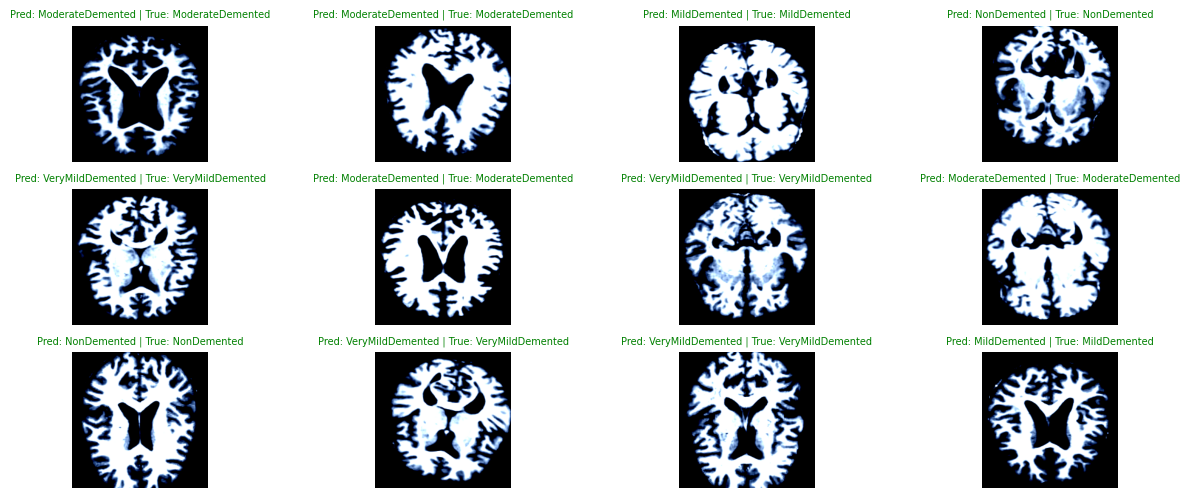

In [32]:
#Take images
data = []
labels = []
for img, label in random.sample(list(dataset), k=12):
  data.append(img.unsqueeze(dim=0))
  labels.append(label)

preds = make_prediction(model=model, data=data, device=device).cpu().numpy()

#Plot
plt.figure(figsize=(15,6))
for i, img in enumerate(data):
  plt.subplot(3,4,i+1)
  plt.imshow(img.squeeze().permute(1,2,0))
  title = f"Pred: {idx_to_class[preds[i]]} | True: {idx_to_class[labels[i]]}"
  if preds[i]==labels[i]:
    plt.title(title, color='green', fontsize=7)
  else:
    plt.title(title, color='red', fontsize=7)
  plt.axis(False)
plt.show()

#**Confusion Matrix**

In [33]:
#Make predictions for all images of val folder
y_preds=[]
y_true=[]
model.eval()
with torch.inference_mode():
  for X, y in dataloader:
    X=X.to(device)
    preds=model(X)

    y_preds.append(preds.argmax(dim=1))
    y_true.append(y)
y_preds, y_true = torch.cat(y_preds), torch.cat(y_true)
y_preds, y_true = y_preds.cpu().numpy(), y_true.numpy()

In [34]:
#Required packages for Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Confusion matrix table
cm = confusion_matrix(y_true=y_true, y_pred=y_preds, labels=range(len(dataset.classes)))
cm

array([[2494,    0,    0,    6],
       [   1, 2499,    0,    0],
       [  12,    0, 2456,   32],
       [   2,    0,   13, 2485]])

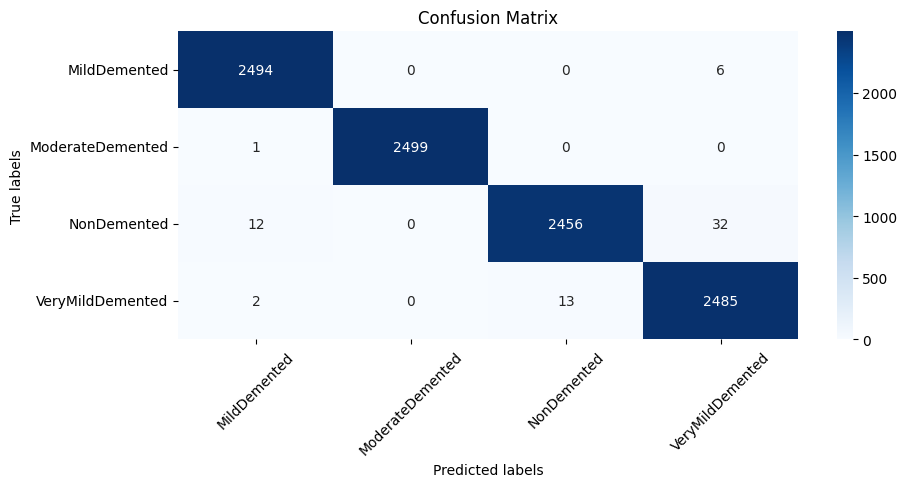

                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      1.00      2500
ModerateDemented       1.00      1.00      1.00      2500
     NonDemented       0.99      0.98      0.99      2500
VeryMildDemented       0.98      0.99      0.99      2500

        accuracy                           0.99     10000
       macro avg       0.99      0.99      0.99     10000
    weighted avg       0.99      0.99      0.99     10000



In [43]:
#Plot confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm,
            annot=True,
            cmap="Blues",
            xticklabels=dataset.classes,
            yticklabels=dataset.classes,
            fmt="d")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

#Metrics calculation
from sklearn.metrics import classification_report

class_names = dataset.classes

report = classification_report(
    y_true,
    y_preds,
    target_names=class_names
)

print(report)

#FINISH✅!!!